## Dataset & DataLoader
: *torch.utils.data.DataLoader*과 *torch.utils.data.Dataset*의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다. 

- Dataset: 샘플과 정답(label)을 저장
- DataLoader: Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다. 
---
- PyTorch의 도메인 특화 라이브러리들은 (FasionMNIST와 같은) 미리 준비해둔 다양한 데이터셋을 제공한다. 
- Dataset은 *torch.utils.data.Dataset*의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다. 
  - 이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark)하는데 사용할 수 있다. 
---
**데이터 셋 링크**
- 이미지 데이터셋(https://pytorch.org/vision/stable/datasets.html)
- 텍스트 데이터셋(https://pytorch.org/text/stable/datasets.html)
- 오디오 데이터셋(https://pytorch.org/audio/stable/datasets.html)

### 데이터셋 불러오기 

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [01:15<00:00, 349127.97it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 52122.98it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 655265.74it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6021270.77it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 데이터셋을 순회하고 시각화하기
: Dataset에 리스트처럼 직접 접근(index)할 수 있다.<br>
: training_data[index]. matplotlib을 사용하여 시각화

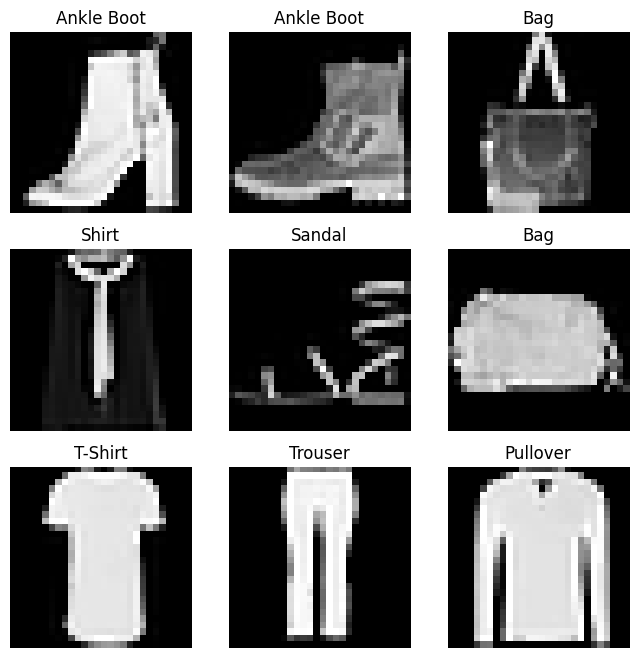

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 파일에서 사용자 정의 데이터셋 만들기
: 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다. <br>
    : _init_, _len_, _getitem_

* FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장된다. 

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### _init_ 함수
: Dataset 객체가 생성될 때 한 번만 실행된다. <br>
: 이미지와 주석 파일이 포함된 디렉토리와 두가지 변형(transform)을 초기화한다. 

In [5]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

#### _len_
: 데이터셋의 샘플 개수를 반환 

In [6]:
def __len__(self):
    return len(self.img_labels)

#### _getitem_
: 주어진 인덱스에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. <br>
* 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별한다. 
*  read_image를 사용하여 이미지를 텐서로 변환한다.
*  self.img_labels의 csv 데이터로부터 해당하는 정답(label)을 가져온다. 
*  (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 python 사전(dict)형으로 반환한다. 

In [12]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

### DataLoader로 학습용 데이터 준비하기
: Dataset은 데이터셋의 특징을 가져오고 하나의 샘플에 정답을 지정하는 일을 한 번에 한다. 

모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달하고, 매 에폭마다 데이터를 다시 섞어서 과적합을 막고, multiprocessing을 사용하여 데이터 컴색 속도를 높이려고 한다. <br>
<br>
DataLoader: 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기 (iterate)
DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다. 

(각각 batch_size=64의 특징과 정답을 포함하는) train_features와 train_labels의 묶음(batch)을 반환한다. <br><br>
shuffle=True로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다. 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


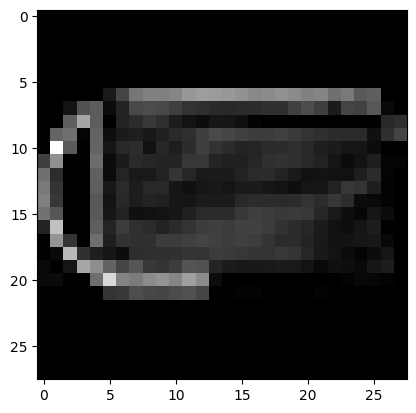

Label: 8


In [30]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")